# Dispersion Curve Computation - Measured Data

@Sabrina Keil

In this jupyter notebook we will extract Rayleigh wave dispersion curves from 6C data measured in Munich, Germany, to reproduce the results of Keil et al. 2022. We will analyze data from location TWI, where also a seismic array was installed to compare to frequency-wavenumber analysis.

![title](./measurement_location.png)

#### The 6C data are analyzed with two approaches:   
1.) A simplified version of ROLODE (Wassermann et al. 2016)    
2.) Twistpy

In [1]:
### Import packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from obspy import read, Stream, read_inventory, UTCDateTime
from obspy.signal.cross_correlation import correlate
from obspy.signal.rotate import rotate_ne_rt
import matplotlib as mpl
from scipy import stats
from twistpy.polarization import DispersionAnalysis
from twistpy.polarization.machinelearning import SupportVectorMachine

### Import dispersion curves from FK analysis

In [2]:
#load dispersion curve from paper Keil et al. 2022
file_FK=pd.read_csv("./Data/FK_ray.csv", delimiter=",")
file_FK.head()

,Frequency,Velocity,Stdev_vel
0,1.917012,1252.311318,0.000000
1,1.951739,1561.777720,578.050027
2,2.045001,1497.771737,524.483459
3,2.082046,1476.872020,511.566162
4,2.318844,1402.460890,402.577492


In [3]:
FK_freq=np.array(file_FK[['Frequency']][:].values[:,0], dtype=float)
FK_ray=np.array(file_FK[['Velocity']][:].values[:,0],dtype=float)
FK_error=np.array(file_FK[['Stdev_vel']][:].values[:,0],dtype=float)

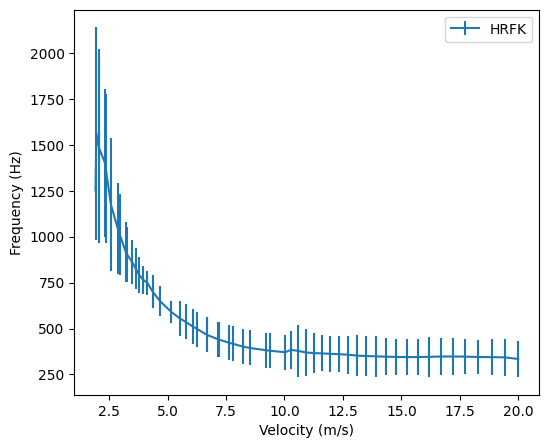

In [4]:
plt.figure(figsize=(6,5))
plt.errorbar(FK_freq, FK_ray,yerr=FK_error, label="HRFK")
plt.legend()
plt.xlabel("Velocity (m/s)")
plt.ylabel("Frequency (Hz)")
plt.show()

### Import measured data

In [5]:
# Import the traces
vel = read('./Data/XX.TWIB.HH.mseed')
rot = read('./Data/XX.TWIB.HJ.mseed') # HJ1=HJE, HJ2=JHN, HJ3=HJZ

print(vel)
print(rot)

3 Trace(s) in Stream:
XX.TWIB..HHZ | 2020-07-13T10:00:00.000000Z - 2020-07-13T11:00:00.000000Z | 200.0 Hz, 720001 samples
XX.TWIB..HHN | 2020-07-13T10:00:00.000000Z - 2020-07-13T11:00:00.000000Z | 200.0 Hz, 720001 samples
XX.TWIB..HHE | 2020-07-13T10:00:00.000000Z - 2020-07-13T11:00:00.000000Z | 200.0 Hz, 720001 samples
3 Trace(s) in Stream:
XX.TWIB..HJ1 | 2020-07-13T10:00:00.001200Z - 2020-07-13T11:00:00.001200Z | 200.0 Hz, 720001 samples
XX.TWIB..HJ2 | 2020-07-13T10:00:00.001200Z - 2020-07-13T11:00:00.001200Z | 200.0 Hz, 720001 samples
XX.TWIB..HJ3 | 2020-07-13T10:00:00.001200Z - 2020-07-13T11:00:00.001200Z | 200.0 Hz, 720001 samples


In [6]:
#inventory
inv= read_inventory('./Data/TWIB.xml')
print(inv)

Inventory created at 2020-07-13T14:21:27.396334Z
	Created by: ObsPy 1.1.1
		    https://www.obspy.org
	Sending institution: LMU
	Contains:
		Networks (1):
			XX
		Stations (1):
			XX.TWIB (Huddle FFB)
		Channels (6):
			XX.TWIB..HHZ, XX.TWIB..HHN, XX.TWIB..HHE, XX.TWIB..HJ1, 
			XX.TWIB..HJ2, XX.TWIB..HJ3


In [7]:
#preprocessing
# remove the trend on the trace
vel.detrend('spline', order= 3, dspline=500)
rot.detrend('spline', order= 3, dspline=500)


# Remove Instrument Response
vel.remove_response(inventory=inv, output="ACC") 
rot.remove_response(inventory=inv, output="VEL")

3 Trace(s) in Stream:
XX.TWIB..HJ1 | 2020-07-13T10:00:00.001200Z - 2020-07-13T11:00:00.001200Z | 200.0 Hz, 720001 samples
XX.TWIB..HJ2 | 2020-07-13T10:00:00.001200Z - 2020-07-13T11:00:00.001200Z | 200.0 Hz, 720001 samples
XX.TWIB..HJ3 | 2020-07-13T10:00:00.001200Z - 2020-07-13T11:00:00.001200Z | 200.0 Hz, 720001 samples

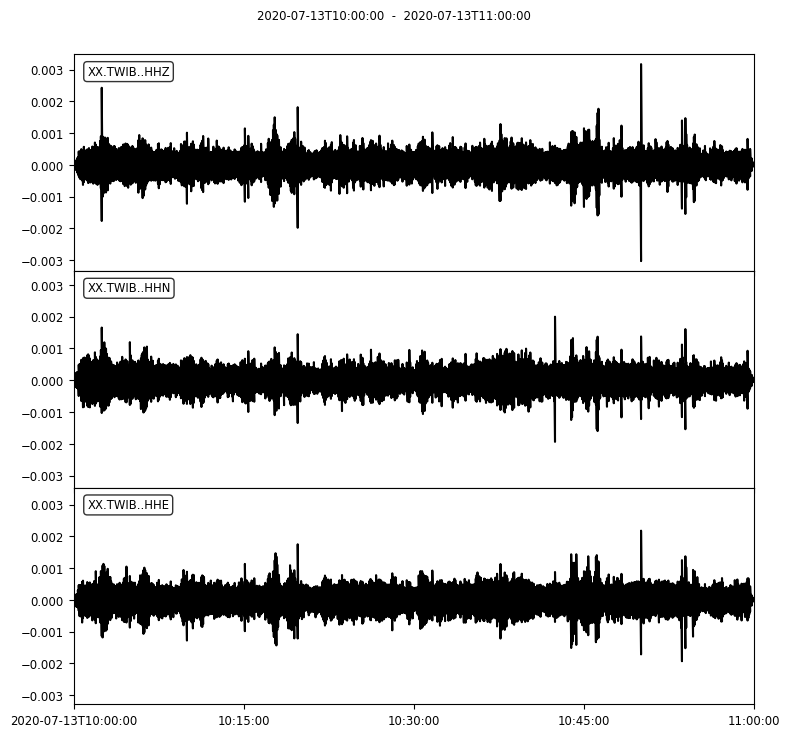

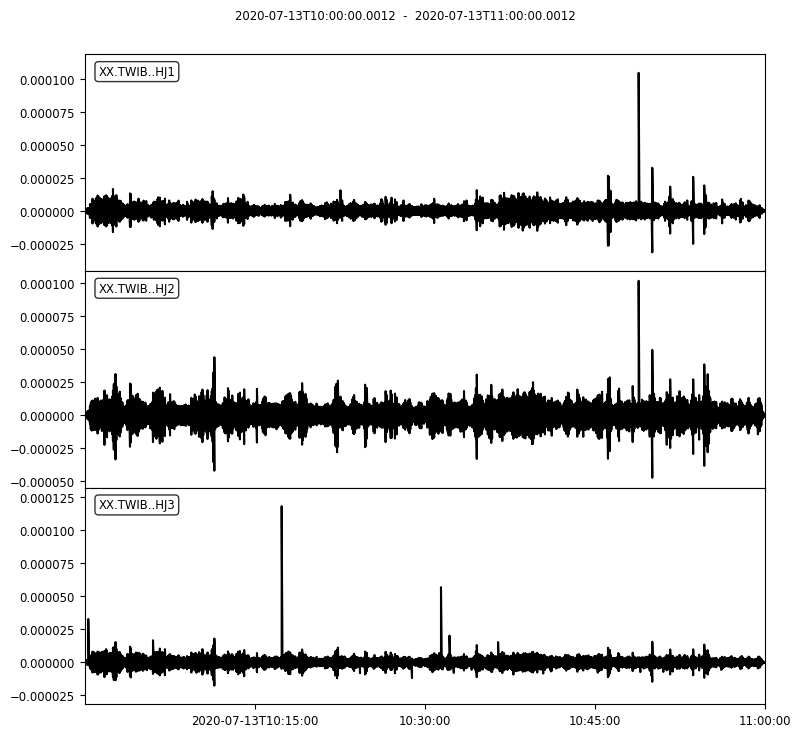

In [8]:
vel.plot()
rot.plot()
plt.show()

## 1.) ROLODE

### 1.1.) Backazimuth

Here we will compute the backazimuth of the Rayleigh waves using polarization analysis of two horizontal rotational components.

In [9]:
#filter

vel_filt=vel.copy().filter("bandpass",freqmin=16,freqmax=20,corners=4,zerophase=True)
rot_filt=rot.copy().filter("bandpass",freqmin=16,freqmax=20,corners=4,zerophase=True)

In [10]:
#select necessary components: Z-component translational data and N- and E-component rotational data
waveforms=[vel_filt[0],rot_filt[0],rot_filt[1]]

################################################################################################
## Parameters that you can change: 

# Starting and ending time (in seconds)
t1 = 50 
t2 = 150  #up to 600s; longer data causes longer processing time

# The length of the moving window and moving steps (in seconds)
win_len = 0.5
win_step = 0.1 
################################################################################################# 

In [11]:
#### Don´t change anything in here !!!!

dt = waveforms[0].stats.delta  #time step
t3 = np.int32(t1/dt)
t4 = np.int32(t2/dt)
wins = np.arange(0,t2-t1,win_step)
num_windows = len(wins) #number of windows to be processed

result_baz = np.empty((num_windows,3))  #store backazimuth results
result_corr = np.empty((num_windows,2)) #store correlation values


baz_cal = []
t = []
corrbaz = []
    
for i_win in wins:  #iterate through the time windows

    t1_1 = t1 + i_win
    t2_1 = t1_1 + win_len
    t3_1 = np.int32(t1_1/dt)  
    t4_1 = np.int32(t2_1/dt)         
        
    data1  = (np.zeros((t4_1-t3_1,2)))    
    data1[:,0] = waveforms[1].data[t3_1:t4_1] #HJE
    data1[:,1] = waveforms[2].data[t3_1:t4_1] #HJN

    #relate north and east component of rotation rate to compute backzimuth
    C = np.cov(data1, rowvar=False)
    Cprime,Q = np.linalg.eigh(C,UPLO='U')
    loc = np.argsort(np.abs(Cprime))[::-1]
    Q = Q[:,loc]
    baz_tmp = -np.arctan((Q[1,0]/Q[0,0]))*180/np.pi 

    if baz_tmp <= 0:
        baz_tmp = baz_tmp + 180.

            
    #remove 180? ambiguity by correlating transverse rotation and vertical translation
    corrbazz = correlate(waveforms[0].data[t3_1:t4_1],
                        rotate_ne_rt(waveforms[1].data[t3_1:t4_1], 
                                        waveforms[2].data[t3_1:t4_1], baz_tmp)[1][:],0)
        
    if (corrbazz[0] > 0):  #if positive correlation then add 180°
        baz_tmp = (180. + baz_tmp)

    baz_cal.append(baz_tmp)
    t.append(t1_1+win_len)
    corrbaz.append(np.abs(corrbazz[0]))
    

baz_cal = np.array(baz_cal)
t = np.array(t)
corrbaz = np.array(corrbaz)
    
result_baz[:,1] = baz_cal
result_corr[:,0] = corrbaz    
result_baz[:,0] = t

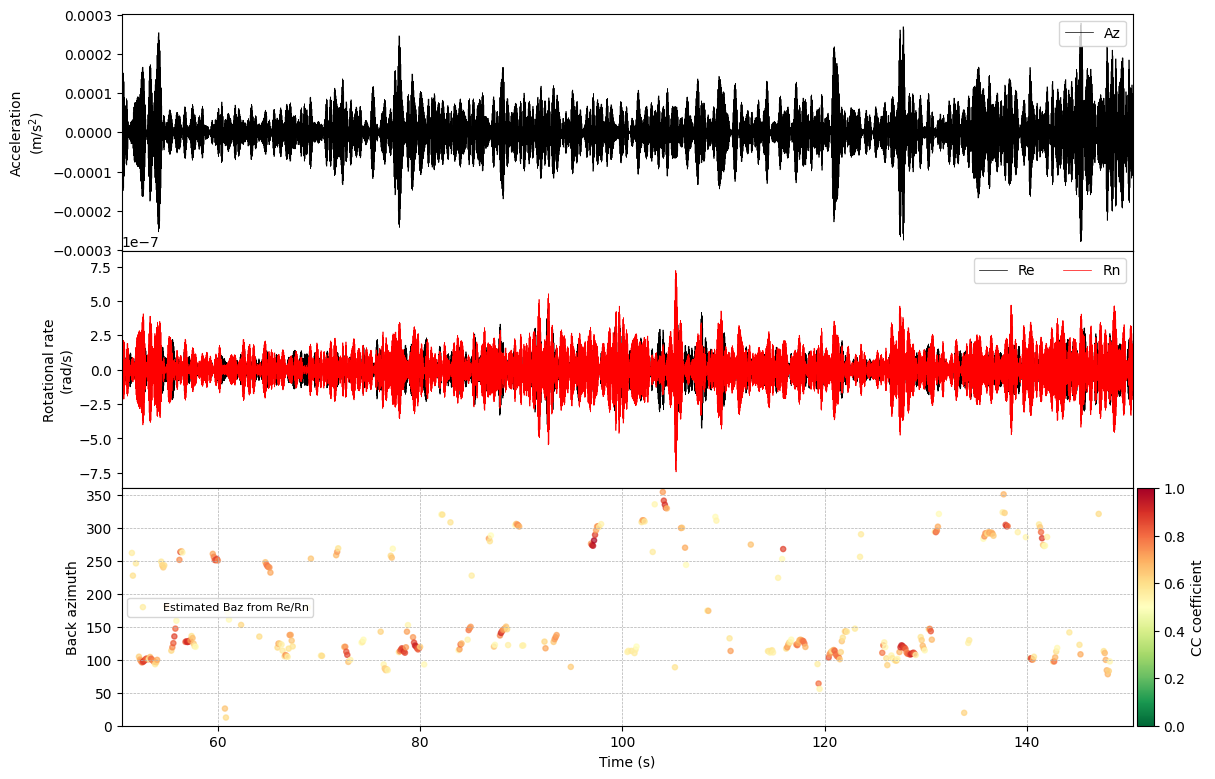

In [12]:
#Plot backazimuth estimates

#########################################
CC = 0.5  # set cross-correlation coefficient threshold for visualization
#########################################

plt.figure(figsize=(12,8))
#compute time axis
time0 = waveforms[0].times()
time1 = waveforms[1].times() 
time2 = np.linspace(t1+win_len,t2+win_len,num_windows)
ylim1 = np.max([np.abs(waveforms[0].data)])/3
ylim2 = np.max([np.abs(waveforms[2].data),\
                np.abs(waveforms[1].data)])/10

# plot time series of Az
ax0 = plt.subplot2grid((3,50),(0,0), colspan=49)
ax0.plot(time0[:],waveforms[0].data,'k',
         linewidth=0.5,label="Az")
ax0.set_xlim(t1+win_len,t2+win_len)
ax0.set_ylim(-ylim1, ylim1)
ax0.set_ylabel("Acceleration\n(m/s$^2$)")
ax0.legend(loc=1,ncol=2,prop={'size':10})
  

# plot time series of Re and Rn
ax1 = plt.subplot2grid((3,50),(1,0), colspan=49,sharex=ax0)
ax1.plot(time1,waveforms[1].data,'k',
         linewidth=0.5,label="Re")
ax1.plot(time1,waveforms[2].data,'r',
         linewidth=0.5,label="Rn")
ax1.set_xlim(t1+win_len,t2+win_len)
ax1.set_ylim(-ylim2,ylim2)
ax1.set_ylabel("Rotational rate\n(rad/s)")
ax1.legend(loc=1,ncol=2,prop={'size':10})   


# add colorbar
fig = plt.subplot2grid((3,50),(2,49))
norm = mpl.colors.Normalize(vmin=0.0,vmax=1)
cb1 = mpl.colorbar.ColorbarBase(fig,cmap=plt.cm.RdYlGn_r,
                                norm=norm,orientation='vertical',label="CC coefficient")

# plot backazimuth from Re/Rn
ax2 = plt.subplot2grid((3,50),(2,0),colspan=49,sharex=ax0)
index = np.where(result_corr[:,0] > CC)  #only plot results with cross-correlation value larger than cc
ax2.scatter(t[index],result_baz[index,1],c=result_corr[index,0],cmap=plt.cm.RdYlGn_r,
            vmin=0.0,vmax=1,marker='.',s=55,alpha=0.7,label='Estimated Baz from Re/Rn')
ax2.set_xlim(t1+win_len,t2+win_len)
ax2.set_ylim(0,360)
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Back azimuth")
ax2.legend(loc=6,ncol=2,prop={'size':8})
ax2.grid(linestyle='--', linewidth=0.5)

plt.subplots_adjust(left=0.09,bottom=0.07,right=0.95,top=0.96,hspace=0.0)
plt.show()

### 1.2.) Rayleigh dispersion curve

In [13]:
def compute_dispersion_ray(vel_z,rot_x,rot_y,f_cent):
    
    ###################################################
    #Some parameters that can be changed:
    
    cc_lim=0.95 #cross-correlation limit
    vel_ray_estimate=[]
    waveforms=[vel_z,rot_x,rot_y]

    # Starting and ending time (in seconds)
    t1 = 0 
    t2 = 3595

    # The length of the moving window and moving steps (in seconds)
    # Window length will depend on the wavelength    
    periods_per_window=8
    win_len = periods_per_window/ f_cent  
    win_step = 0.1  
    ################################################### 

    ## from here on don´t change anything!!
    dt = waveforms[0].stats.delta
    t3 = np.int32(t1/dt)
    t4 = np.int32(t2/dt)
    wins = np.arange(0,t2-t1,win_step)
    num_windows = len(wins) 

    result_baz = np.empty((num_windows,3))
    result_corr = np.empty((num_windows,2))


    baz_cal = []
    t = []
    corrbaz = []
    
    for i_win in wins:
        t1_1 = t1 + i_win
        t2_1 = t1_1 + win_len
        t3_1 = np.int32(t1_1/dt)  
        t4_1 = np.int32(t2_1/dt)         
        
        data1  = (np.zeros((t4_1-t3_1,2)))    
        data1[:,0] = waveforms[1].data[t3_1:t4_1] #HJE
        data1[:,1] = waveforms[2].data[t3_1:t4_1] #HJN

        #relate north and east component of rotation rate to compute backzimuth
        C = np.cov(data1, rowvar=False)
        Cprime,Q = np.linalg.eigh(C,UPLO='U')
        loc = np.argsort(np.abs(Cprime))[::-1]
        Q = Q[:,loc]
        baz_tmp = -np.arctan((Q[1,0]/Q[0,0]))*180/np.pi 

        if baz_tmp <= 0:
            baz_tmp = baz_tmp + 180.

            
        #remove 180? ambiguity
        corrbazz = correlate(waveforms[0].data[t3_1:t4_1],
                        rotate_ne_rt(waveforms[1].data[t3_1:t4_1], 
                                        waveforms[2].data[t3_1:t4_1], baz_tmp)[1][:],0)
        
        if (corrbazz[0] > 0):
            baz_tmp = (180. + baz_tmp)
                
                
                
        baz_calc=baz_tmp
        cc_calc=abs(corrbazz[0]) 
        
#############################################################################################        
        #compute velocity only for parts with high correlation coefficient
        if cc_calc>=cc_lim:
            rot_T=rotate_ne_rt(waveforms[2].data[t3_1:t4_1], 
                                          waveforms[1].data[t3_1:t4_1], baz_calc)[1]
                
            vel_z=waveforms[0].data[t3_1:t4_1]
               
            #make rot_T suitable for linear regression
            A_R =np.vstack([np.array(rot_T), np.ones(len(np.array(rot_T)))]).T
            
            ##relate vertical translation and transverse rotation and solve with least squares approach
            m_R, c_R = np.linalg.lstsq(abs(A_R), abs(np.array(vel_z)), rcond=None)[0] #m_R represents the slope of the best-fit line.
                                                                                    #c_R represents the intercept
            vel_ray_estimate.append(abs(m_R))
                
    print(np.shape(vel_ray_estimate))
    return vel_ray_estimate

In [14]:
#For dispersion curve estimation filter in small frequency bands
f_min=3
f_max=25  

f_lower = []
f_higher = []
f_center=[]
fcenter = f_max
first = True

    
#we try half octave band filtering
#while fcenter > f_min:
#    f_l = fcenter/(np.sqrt((np.sqrt(2.))))
#    f_u = fcenter*(np.sqrt((np.sqrt(2.))))
#    f_lower.append(f_l)
#    f_higher.append(f_u)
 #   fcenter = fcenter/((np.sqrt(2.)))
#    f_center.append(fcenter)
    
while fcenter > f_min:
    f_l = fcenter/(np.sqrt(np.sqrt((np.sqrt(2.)))))
    f_u = fcenter*(np.sqrt(np.sqrt((np.sqrt(2.)))))
    f_lower.append(f_l)
    f_higher.append(f_u)
    fcenter = fcenter/((np.sqrt(np.sqrt(2.))))
    f_center.append(fcenter)

In [15]:
#Filter data
rot_x_filt=[]
rot_y_filt=[]
vel_z_filt=[]

for n in range(len(f_lower)):
    rotx_filt=rot[0].copy().filter("bandpass",freqmin=f_lower[n],freqmax=f_higher[n],corners=4,zerophase=True)
    roty_filt=rot[1].copy().filter("bandpass",freqmin=f_lower[n],freqmax=f_higher[n],corners=4,zerophase=True)
    velz_filt=vel[0].copy().filter("bandpass",freqmin=f_lower[n],freqmax=f_higher[n],corners=4,zerophase=True)
    
    rot_x_filt.append(rotx_filt)
    rot_y_filt.append(roty_filt)
    vel_z_filt.append(velz_filt)

In [16]:
ray_vel_kde=[]
ray_vel_rolode=[]
ray_stdev=[]

for n in range(len(rot_x_filt)):
    vel_ray_estimate=compute_dispersion_ray(vel_z=vel_z_filt[n],rot_x=rot_x_filt[n],rot_y=rot_y_filt[n],f_cent=f_center[n])
    ray_vel_kde.append(vel_ray_estimate)
    ray_stdev.append(np.std(vel_ray_estimate))
    ## pick maximum in histogram as velocity estimate
    kde = stats.gaussian_kde(abs(np.array(vel_ray_estimate)))
    xx = np.linspace(0, 1000, 1000)
    kde_values = kde(xx)
    max_index = np.argmax(kde_values)  # Index of peak
    mode_value = xx[max_index]  # x-value of peak
    ray_vel_rolode.append(mode_value)

(232,)
(334,)
(283,)
(224,)
(125,)
(141,)
(185,)
(152,)
(100,)
(154,)
(86,)
(57,)
(46,)


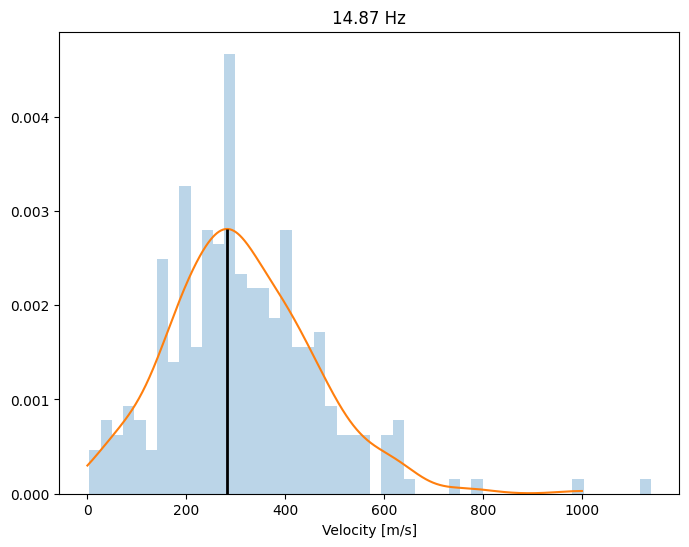

In [17]:
## visualize one histogram
n=2
kde = stats.gaussian_kde(abs(np.array(ray_vel_kde[n])))
xx = np.linspace(0, 1000, 1000)
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(abs(np.array(ray_vel_kde[n])),bins=50, density=True, alpha=0.3)
ax.plot(xx, kde(xx))
plt.vlines(x=ray_vel_rolode[n],ymin=0,ymax=max(kde(xx)),color="black",linewidth=2)
plt.xlabel("Velocity [m/s]")
plt.title("{} Hz".format(round(f_center[n],2)))
plt.show()

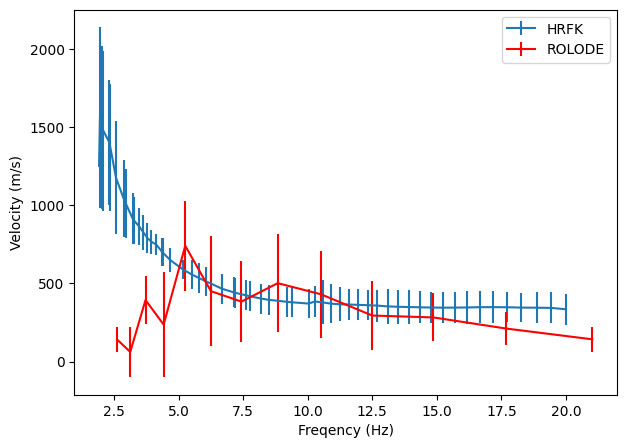

In [18]:
plt.figure(figsize=(7,5))
plt.errorbar(FK_freq, FK_ray,yerr=FK_error, label="HRFK")
plt.errorbar(f_center,ray_vel_rolode,yerr=ray_stdev,color="red",label="ROLODE")
plt.legend()
plt.xlabel("Freqency (Hz)")
plt.ylabel("Velocity (m/s)")
#plt.ylim(200,1200)
plt.show()

## 2.)Twistpy

In [64]:
#select data
data=Stream([vel[0].copy(),vel[1].copy(),vel[2].copy(),rot[2].copy(),rot[1].copy(),rot[0].copy()])
print(data)

6 Trace(s) in Stream:
XX.TWIB..HHZ | 2020-07-13T10:00:00.000000Z - 2020-07-13T11:00:00.000000Z | 200.0 Hz, 720001 samples
XX.TWIB..HHN | 2020-07-13T10:00:00.000000Z - 2020-07-13T11:00:00.000000Z | 200.0 Hz, 720001 samples
XX.TWIB..HHE | 2020-07-13T10:00:00.000000Z - 2020-07-13T11:00:00.000000Z | 200.0 Hz, 720001 samples
XX.TWIB..HJ3 | 2020-07-13T10:00:00.001200Z - 2020-07-13T11:00:00.001200Z | 200.0 Hz, 720001 samples
XX.TWIB..HJ2 | 2020-07-13T10:00:00.001200Z - 2020-07-13T11:00:00.001200Z | 200.0 Hz, 720001 samples
XX.TWIB..HJ1 | 2020-07-13T10:00:00.001200Z - 2020-07-13T11:00:00.001200Z | 200.0 Hz, 720001 samples


With TwistPy, dispersion curves are estimated by 6C polarization analysis. First, Rayleigh waves and Love waves are detected using a machine learning algorithm. In time windows, where a Love or Rayleigh wave is detected, the phase velocity and ellipticity is estimated from the first eigenvector of the data covariance matrix. For polarization analysis, we convert our data to dimensionless units by scaling the translational components with a scaling velocity. After scaling, the translational and rotational components should have comparable amplitudes. This makes the analysis more stable.

In [65]:
scaling_velocity = 700.0
for i, trace in enumerate(data):
    if i < 3:
        trace.data /= scaling_velocity
    else:
        trace.data -= np.median(
            trace.data
        )  # Ensure that the rotational components have a median of 0
    trace.taper(0.05)

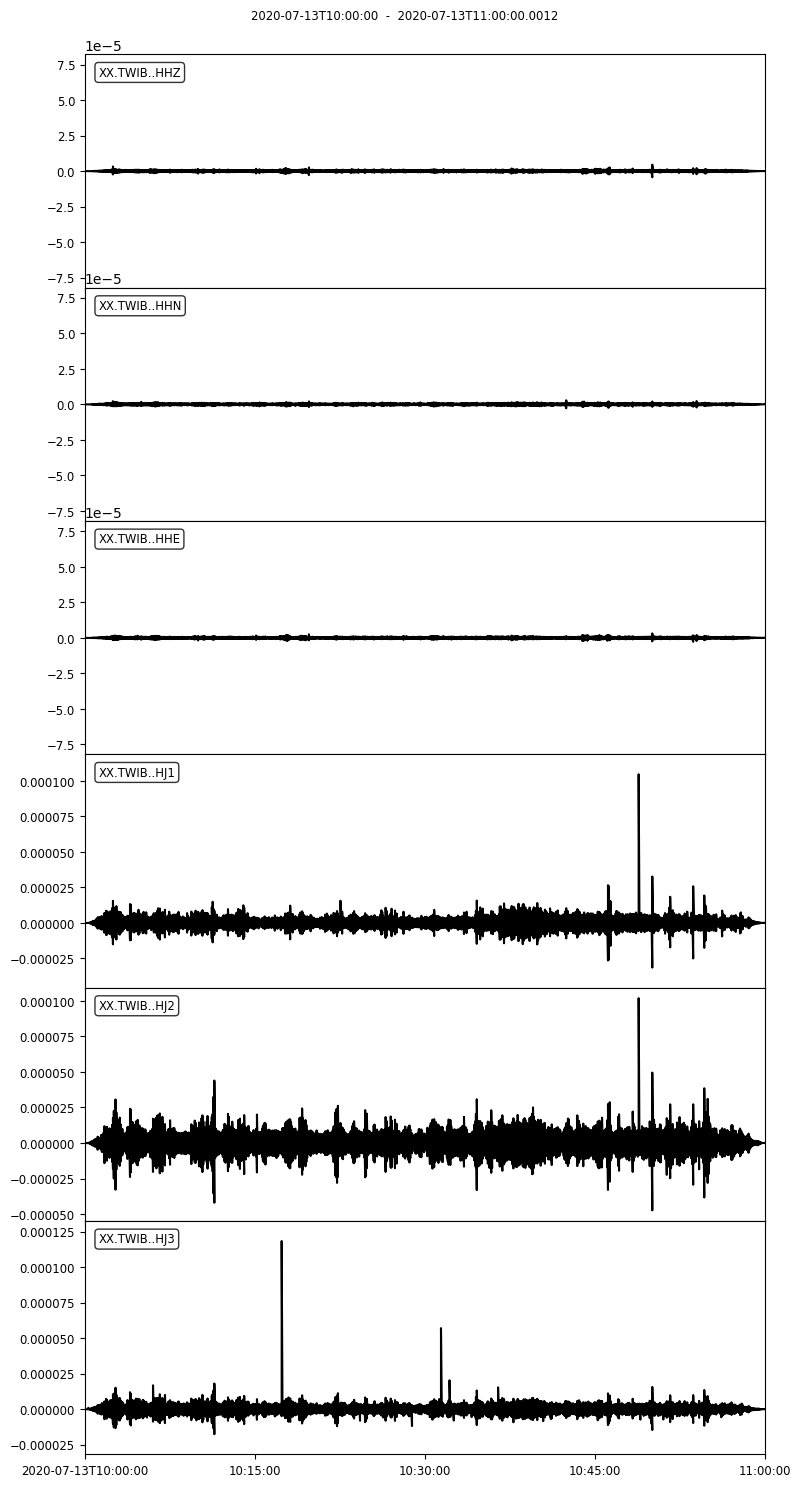

In [66]:
#plot scaled data
data.plot()
plt.show()

Now we train the machine learning model for the detection of Love and Rayleigh waves. We additionally train the model to be able to detect body waves because we want to avoid leakage of body waves into our Love and Rayleigh wave dispersion curves. We choose a velocity range that is typical for the near-surface in the frequency range we are interested in.

Generating random polarization models for training! 

Training Support Vector Machine!
Training successfully completed. Model score on independent test data is '0.9918'!
Model has been saved as 'c:\users\sabrina keil\twistpy\twistpy\SVC_models\dispersion_analysis_measured.pkl'!'


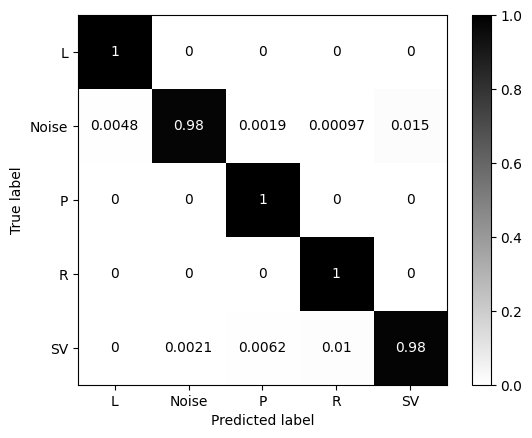

In [68]:
svm = SupportVectorMachine(name="dispersion_analysis_measured")
svm.train(
    wave_types=["R", "L", "P", "SV", "Noise"],
    scaling_velocity=scaling_velocity,
    phi=(0, 360),
    vp=(100, 1500),
    vp_to_vs=(1.5, 2.5),
    vr=(50, 1500),
    vl=(50, 1500),
    xi=(-90, 90),
    theta=(0, 80),
    C=100,
    plot_confusion_matrix=True,
)

We now have everything we need to extract dispersion curves from our ambient noise data. We specify that the time window for the analysis should stretch over 5 dominant periods at each frequency of interest. Additionally, we specify that neighbouring windows should overlap by half the window width in this case (‘overlap’: 0.5). We want to extract Love and Rayleigh wave dispersion curves in the frequency range between 1 and 20 Hz. The data is automatically filtered to various frequency bands in the interval 1 to 20 Hz, each frequency band extends over the number of octaves specified by the parameter ‘octaves’. Here, we choose quarter octave frequency bands.

In [69]:
window = {"number_of_periods": 5, "overlap": 0.5}
da = DispersionAnalysis(
    traN=data[1],
    traE=data[2],
    traZ=data[0],
    rotN=data[4],
    rotE=data[5],
    rotZ=data[3],
    window=window,
    scaling_velocity=scaling_velocity,
    verbose=True,
    fmin=1.0,
    fmax=20.0,
    octaves=0.25,
    svm=svm,
)

Estimating surface wave parameters at frequency f =  20.00 Hz. Frequency step 1 out of 18.
Estimating surface wave parameters at frequency f =  16.82 Hz. Frequency step 2 out of 18.
Estimating surface wave parameters at frequency f =  14.14 Hz. Frequency step 3 out of 18.
Estimating surface wave parameters at frequency f =  11.89 Hz. Frequency step 4 out of 18.
Estimating surface wave parameters at frequency f =  10.00 Hz. Frequency step 5 out of 18.
Estimating surface wave parameters at frequency f =  8.41 Hz. Frequency step 6 out of 18.
Estimating surface wave parameters at frequency f =  7.07 Hz. Frequency step 7 out of 18.
Estimating surface wave parameters at frequency f =  5.95 Hz. Frequency step 8 out of 18.
Estimating surface wave parameters at frequency f =  5.00 Hz. Frequency step 9 out of 18.
Estimating surface wave parameters at frequency f =  4.20 Hz. Frequency step 10 out of 18.
Estimating surface wave parameters at frequency f =  3.54 Hz. Frequency step 11 out of 18.
Est

C:\Users\Sabrina Keil\anaconda3\envs\twistpy\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
C:\Users\Sabrina Keil\anaconda3\envs\twistpy\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Sabrina Keil\anaconda3\envs\twistpy\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


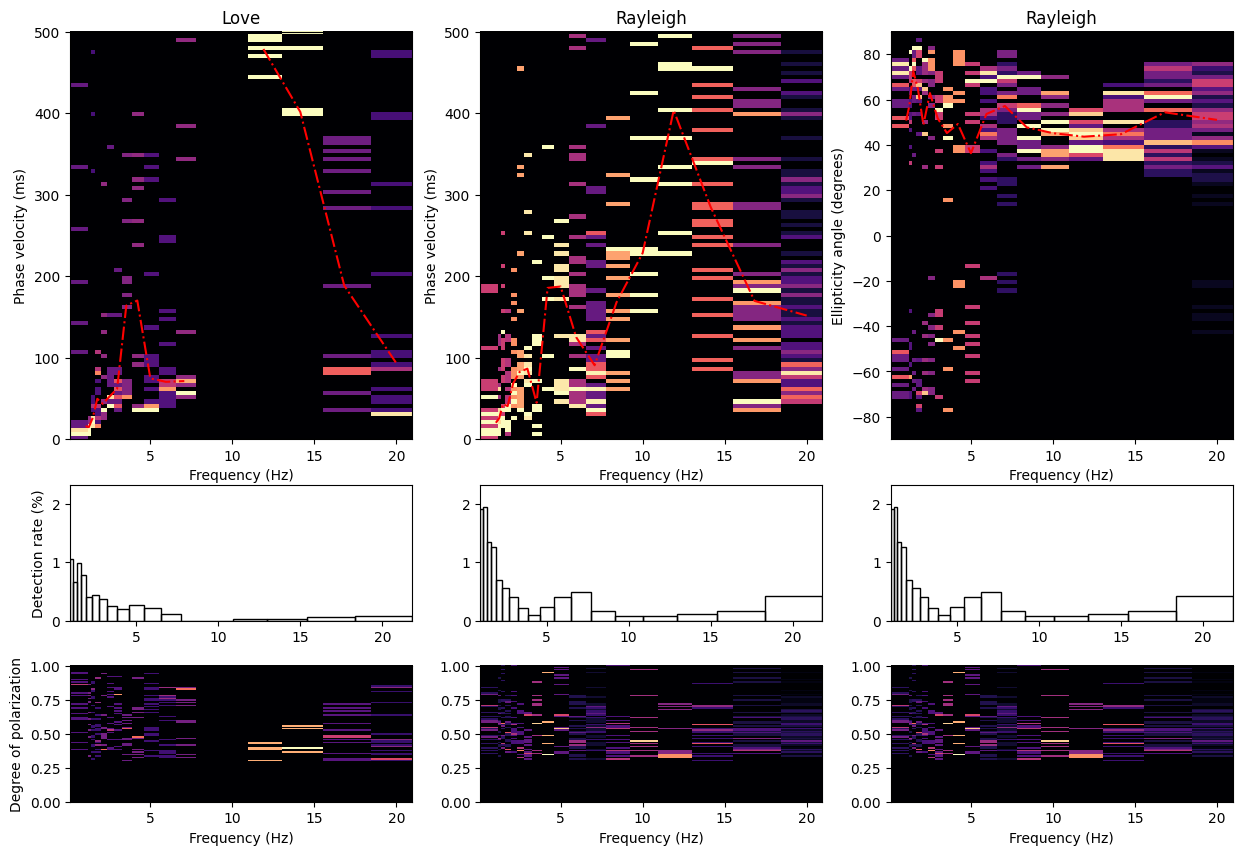

In [70]:
#plot results
da.plot(velocity_range=(0,500))

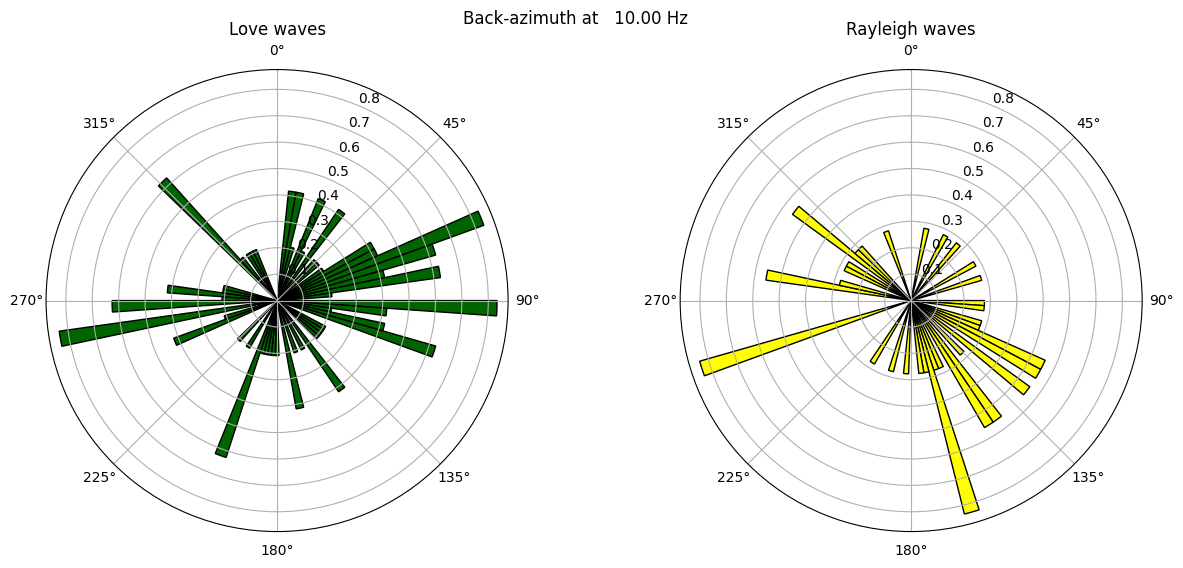

In [71]:
#plot backazimuth estimation
da.plot_baz(freq=10.0)

In [72]:
results=da.__dict__
freq_twist=results["f"]
print(freq_twist)
results_data=results["parameters"]

[20.0, 16.817928305074293, 14.142135623730953, 11.892071150027213, 10.000000000000002, 8.408964152537147, 7.071067811865476, 5.946035575013607, 5.000000000000001, 4.204482076268573, 3.535533905932738, 2.9730177875068033, 2.5000000000000004, 2.1022410381342866, 1.767766952966369, 1.4865088937534017, 1.2500000000000002, 1.0511205190671433]


In [73]:
twistpy_ray=[]
for n in range(len(results_data)):
    arr=results_data[n]["c_r"]
    median_value = np.nanmedian(arr)
    twistpy_ray.append(median_value)

In [74]:
twistpy_lov=[]
for n in range(len(results_data)):
    arr=results_data[n]["c_l"]
    median_value = np.nanmedian(arr)
    twistpy_lov.append(median_value)

## Compare results

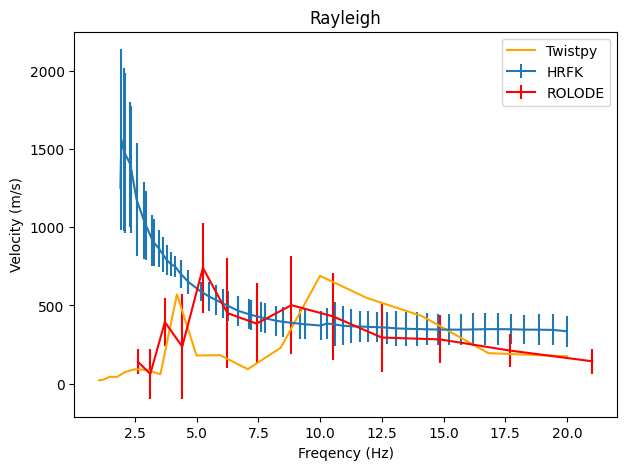

In [75]:
#plot all dispersion curves as comparison
plt.figure(figsize=(7,5))
plt.errorbar(FK_freq, FK_ray,yerr=FK_error, label="HRFK")
plt.errorbar(f_center,ray_vel_rolode,yerr=ray_stdev,color="red",label="ROLODE")
plt.plot(freq_twist,np.array(twistpy_ray),color="orange",label="Twistpy")
plt.legend()
plt.xlabel("Freqency (Hz)")
plt.ylabel("Velocity (m/s)")
plt.title("Rayleigh")
plt.show()

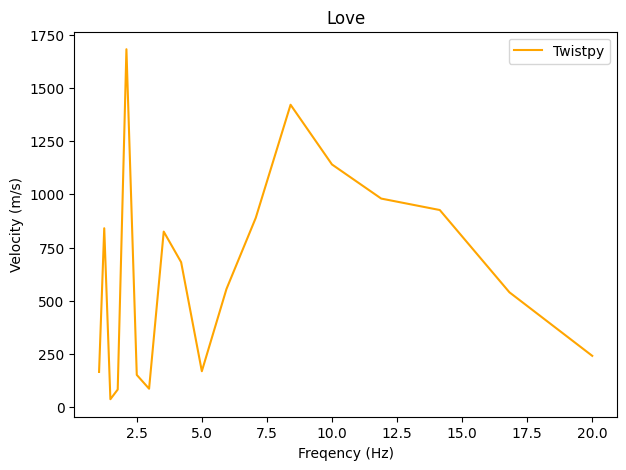

In [76]:
#plot all dispersion curves for Love waves
plt.figure(figsize=(7,5))
#plt.plot(freq_lov,vel_lov,color="blue",label="HRFK")
plt.plot(freq_twist,twistpy_lov,color="orange",label="Twistpy")
plt.legend()
plt.xlabel("Freqency (Hz)")
plt.ylabel("Velocity (m/s)")
plt.title("Love")
plt.show()